In [2]:
import collections
import pickle
import functools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab

%matplotlib inline

In [3]:
with open('basic_buckets.pkl', 'rb') as f:
    buckets = pickle.load(f)
for i in range(len(buckets)):
    if buckets[i] == 6:
        buckets[i] = [6]
    buckets[i] = list(buckets[i])

In [4]:
buckets[140:160]

[[6, 3, 3, 0],
 [6, 4, 3, 0],
 [7, 1, 4, 1],
 [6, 2, 3, 1],
 [2, 1, 4, 1],
 [1, 1, 4, 1],
 [0, 2, 1, 1],
 [1, 2, 4, 1],
 [2, 2, 6, 1],
 [2, 3, 6, 1],
 [0, 1, 2, 1],
 [0, 2, 2, 1],
 [2, 1],
 [3, 1],
 [5, 1],
 [7, 1, 4, 0],
 [6, 1, 4, 0],
 [7, 1, 6, 0],
 [7, 2, 6, 0],
 [7, 3, 6, 0]]

In [5]:
counts = collections.defaultdict(collections.Counter)
for i in range(len(buckets) - 1):
    if buckets[i] != [6] and buckets[i+1] != [6]:
        start = buckets[i][:-1]
        end = buckets[i+1][:-1]
        if buckets[i][-1] == buckets[i+1][-1]:
            end.append(0)
        else:
            end.append(1)
    
        counts[tuple(start)][tuple(end)] += 1

In [6]:
#remove states we can't support
counter = 0
updated = True
while updated:
    updated = False
    for bucket_start in counts:
        for bucket_end in counts[bucket_start]:
            end = list(bucket_end)[:-1]
            if tuple(end) not in counts and counts[bucket_start][bucket_end]:
                counts[bucket_start][bucket_end] = 0
                counter += 1
                updated = True
    
print(counter)

5


In [7]:
for bucket_start in counts:
    if sum(counts[bucket_start].values()) == 0:
        print('bad')

In [8]:
probabilities = collections.defaultdict(dict)
for bucket_start in counts:
    total = sum(counts[bucket_start].values())
    for bucket_end in counts[bucket_start]:
        if counts[bucket_start][bucket_end]:
            probabilities[bucket_start][bucket_end] = counts[bucket_start][bucket_end] / total

In [9]:
probabilities[list(probabilities.keys())[0]]

{(0, 1, 0, 0): 0.0016941973739940702,
 (0, 1, 1, 0): 0.0012706480304955528,
 (0, 1, 2, 0): 0.002964845404489623,
 (0, 1, 3, 0): 0.0016941973739940702,
 (0, 1, 4, 0): 0.0008470986869970351,
 (0, 1, 4, 1): 0.00042354934349851756,
 (1, 1, 4, 0): 0.023295213892418468,
 (2, 0): 0.007200338839474798,
 (2, 1): 0.00042354934349851756,
 (2, 1, 4, 0): 0.06480304955527319,
 (2, 1, 4, 1): 0.0012706480304955528,
 (3, 1, 4, 0): 0.21516306649724692,
 (3, 1, 4, 1): 0.00042354934349851756,
 (3, 2, 0, 0): 0.0033883947479881405,
 (3, 3, 0, 0): 0.0529436679373147,
 (3, 3, 0, 1): 0.00042354934349851756,
 (3, 3, 1, 0): 0.027530707327403644,
 (3, 3, 2, 0): 0.0025412960609911056,
 (4, 1, 4, 0): 0.05040237187632359,
 (4, 1, 4, 1): 0.0038119440914866584,
 (4, 1, 5, 0): 0.00042354934349851756,
 (4, 2, 0, 0): 0.004235493434985175,
 (4, 2, 2, 0): 0.0012706480304955528,
 (4, 2, 3, 0): 0.00042354934349851756,
 (4, 2, 4, 0): 0.005506141465480729,
 (4, 2, 5, 0): 0.005082592121982211,
 (4, 3, 0, 0): 0.08894536213468869

In [10]:
probabilities[(3,)]

{(5, 0): 1.0}

In [11]:
rewards = collections.defaultdict(int)
rewards[(0,0)] = 3
rewards[(1,0)] = 2
rewards[(2,0)] = 6
rewards[(3,0)] = 1
rewards[(4,0)] = 2
for pair in list(rewards.keys()):
    rewards[(pair[0], 1-pair[1])] = -rewards[pair]
print(rewards)

defaultdict(<class 'int'>, {(0, 1): -3, (2, 0): 6, (0, 0): 3, (3, 0): 1, (1, 0): 2, (3, 1): -1, (4, 1): -2, (1, 1): -2, (2, 1): -6, (4, 0): 2})


In [12]:
THRESHOLD = 10**-8

@functools.lru_cache(maxsize = None)
def predicted_score_difference(current_state, num_turns_left):
    if num_turns_left == 0:
        answer = collections.defaultdict(float)
        answer[rewards[current_state]] = 1.0
        return answer
    
    child_score_diffs = collections.defaultdict(float)
    state,pos = current_state[:-1], current_state[-1]
    for child_state in probabilities[state]:
        p = probabilities[state][child_state]
        child_state = list(child_state)
        child_state[-1] = (pos + child_state[-1]) % 2
        child_state = tuple(child_state)
        child_answer = predicted_score_difference(child_state, num_turns_left - 1)
        for score_diff in child_answer:
            child_score_diffs[score_diff] += p * child_answer[score_diff]
    
    answer = collections.defaultdict(float)
    for score_diff in child_score_diffs:
        if child_score_diffs[score_diff] > THRESHOLD:
            answer[score_diff + rewards[current_state]] = child_score_diffs[score_diff]
    return answer
    

In [13]:
pdf = predicted_score_difference((4, 2, 2,0), 200)

In [19]:
score_diff = []
probability = []
for s, p in sorted(pdf.items()):
    score_diff.append(s)
    probability.append(p)

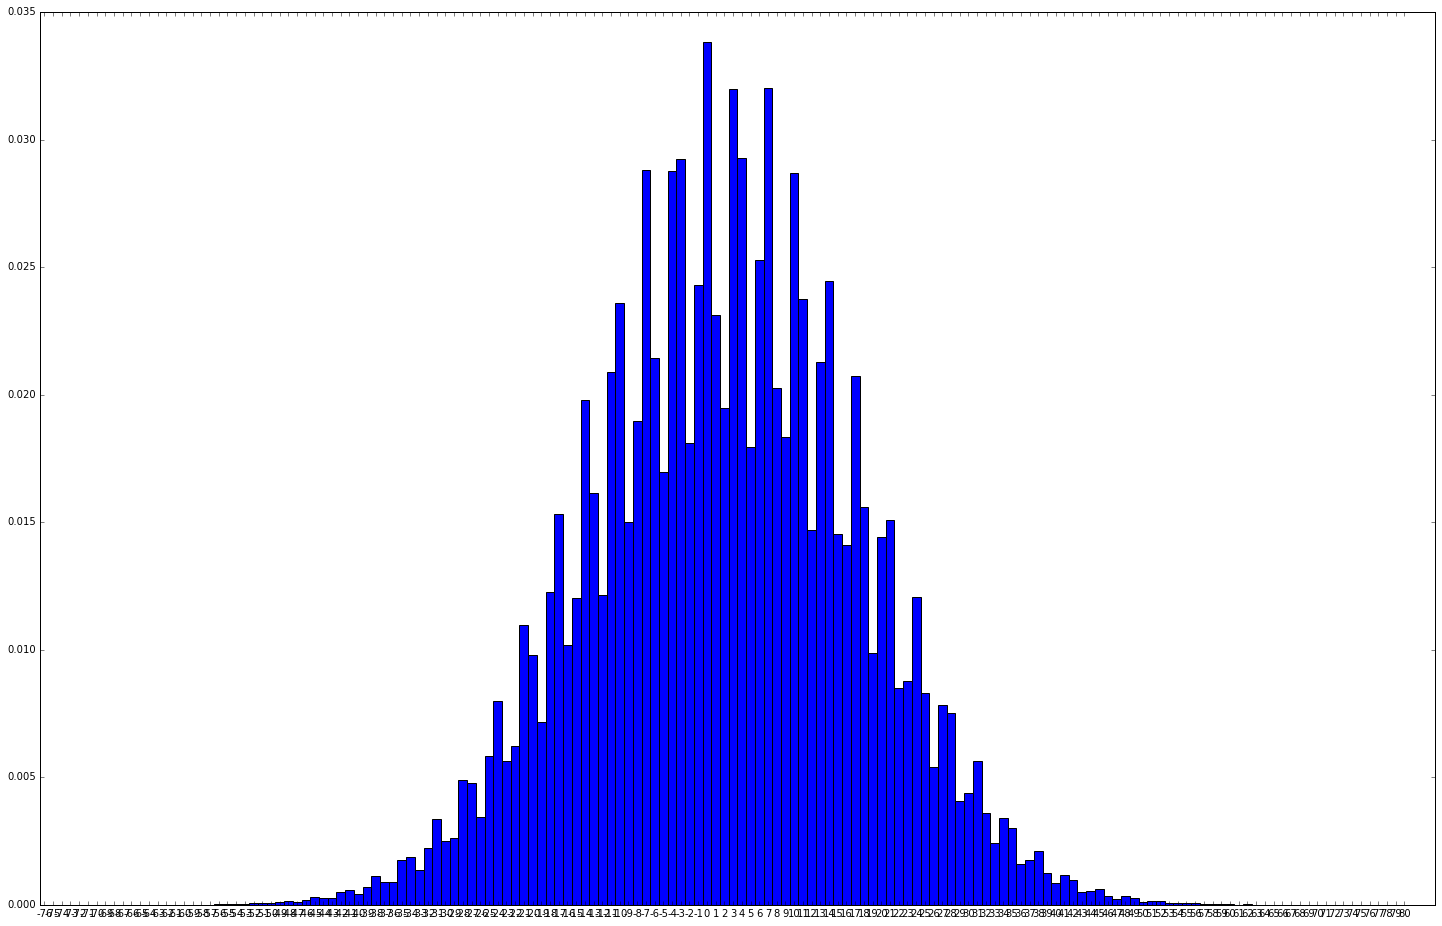

In [21]:
pylab.rcParams['figure.figsize'] = (25.0, 16.0)
indexes = np.arange(len(score_diff))
width = 1

plt.bar(indexes, probability, width)
plt.xticks(indexes + width * 0.5, score_diff)
plt.show()